<a href="https://colab.research.google.com/github/asheta66/Machine-Learning-2024/blob/main/OSA/GA_FFNN_OSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

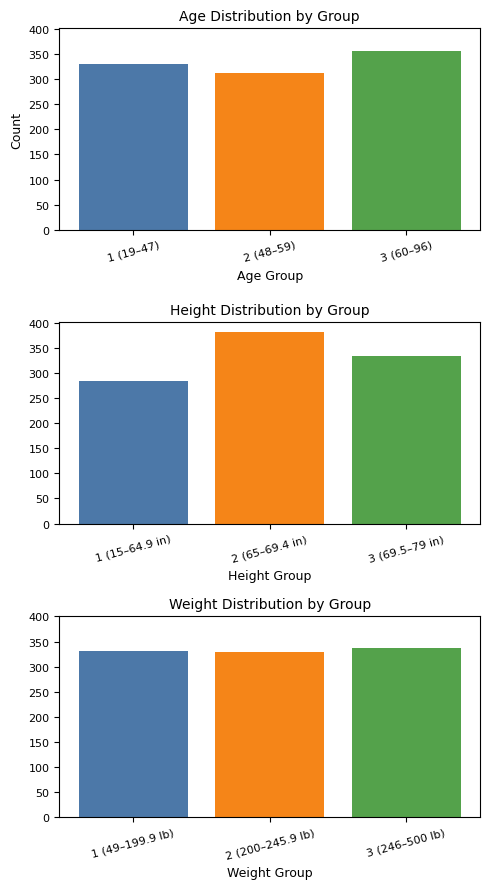

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

# ---------- Load ----------
df = pd.read_csv("OSA_Data_Feb_2023.csv")

# ---------- Define bins ----------
age_bins    = [19, 48, 60, 96]
height_bins = [15.0, 65.0, 69.5, 79.0]
weight_bins = [49.0, 200.0, 246.0, 500.0]

# ---------- Create numeric grouped columns (1, 2, 3) ----------
# Using left-closed, right-open intervals to match your earlier setup
df_with_groups = df.copy()
df_with_groups["Age_Group"] = pd.cut(
    df_with_groups["Age"], bins=age_bins, labels=[1, 2, 3],
    right=False, include_lowest=True, ordered=True
).astype("Int64")

df_with_groups["Height_Group"] = pd.cut(
    df_with_groups["Height (in)"], bins=height_bins, labels=[1, 2, 3],
    right=False, include_lowest=True, ordered=True
).astype("Int64")

df_with_groups["Weight_Group"] = pd.cut(
    df_with_groups["Weight (lb)"], bins=weight_bins, labels=[1, 2, 3],
    right=False, include_lowest=True, ordered=True
).astype("Int64")

# ---------- Save full dataset with all original columns + new numeric groups ----------
df_with_groups.to_csv("OSA_Data_with_Groups.csv", index=False)

# ---------- Prepare counts (ensure order 1,2,3) ----------
age_counts    = df_with_groups["Age_Group"].value_counts().reindex([1, 2, 3])
height_counts = df_with_groups["Height_Group"].value_counts().reindex([1, 2, 3])
weight_counts = df_with_groups["Weight_Group"].value_counts().reindex([1, 2, 3])

# Labels for plotting
age_labels    = ["1 (19–47)", "2 (48–59)", "3 (60–96)"]
height_labels = ["1 (15–64.9 in)", "2 (65–69.4 in)", "3 (69.5–79 in)"]
weight_labels = ["1 (49–199.9 lb)", "2 (200–245.9 lb)", "3 (246–500 lb)"]

# ---------- Plot figure with 3 subplots ----------#
fig, axes = plt.subplots(3, 1, figsize=(5, 9), sharey=True)

# Use varied bar colors
bar_colors = ["#4C78A8", "#F58518", "#54A24B"]  # three distinct colors
x_positions = [0, 1, 2]  # positions for bars

# Age
axes[0].bar(x_positions, age_counts.values, color=bar_colors)
axes[0].set_title("Age Distribution by Group", fontsize=10)
axes[0].set_xlabel("Age Group", fontsize=9)
axes[0].set_ylabel("Count", fontsize=9)
axes[0].set_xticks(x_positions)
axes[0].set_xticklabels(age_labels, rotation=15)
axes[0].tick_params(axis='both', labelsize=8)

# Height
axes[1].bar(x_positions, height_counts.values, color=bar_colors)
axes[1].set_title("Height Distribution by Group", fontsize=10)
axes[1].set_xlabel("Height Group", fontsize=9)
axes[1].set_xticks(x_positions)
axes[1].set_xticklabels(height_labels, rotation=15)
axes[1].tick_params(axis='both', labelsize=8)

# Weight
axes[2].bar(x_positions, weight_counts.values, color=bar_colors)
axes[2].set_title("Weight Distribution by Group", fontsize=10)
axes[2].set_xlabel("Weight Group", fontsize=9)
axes[2].set_xticks(x_positions)
axes[2].set_xticklabels(weight_labels, rotation=15)
axes[2].tick_params(axis='both', labelsize=8)

fig.tight_layout()

# Display and save
plt.show()
fig.savefig("group_distributions_subplots.png", dpi=200, bbox_inches="tight")
plt.close(fig)


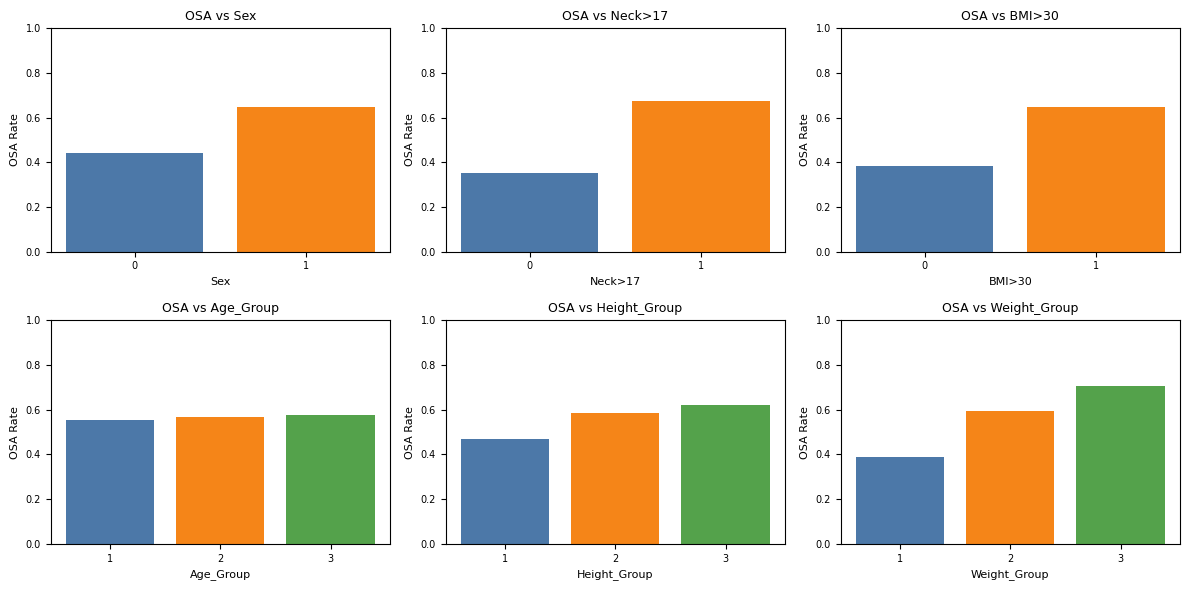

In [ ]:
import matplotlib.pyplot as plt

# List of features to compare with OSA
features = ["Sex", "Neck>17", "BMI>30", "Age_Group", "Height_Group", "Weight_Group"]

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()

bar_colors = ["#4C78A8", "#F58518", "#54A24B", "#E45756"]  # distinct colors

for i, feature in enumerate(features):
    # Calculate OSA prevalence per category
    means = df_with_groups.groupby(feature)["OSA"].mean()

    x_labels = means.index.astype(str)
    y_values = means.values

    axes[i].bar(x_labels, y_values, color=bar_colors[:len(x_labels)])
    axes[i].set_title(f"OSA vs {feature}", fontsize=9)
    axes[i].set_xlabel(feature, fontsize=8)
    axes[i].set_ylabel("OSA Rate", fontsize=8)
    axes[i].tick_params(axis='both', labelsize=7)
    axes[i].set_ylim(0, 1)  # since OSA rate is between 0 and 1

fig.tight_layout()

# Display and save
plt.show()
fig.savefig("osa_relationship_bars.png", dpi=200, bbox_inches="tight")
plt.close(fig)


In [ ]:
"""
GA-ANN Binary Classifier for OSA (NaN-safe, 80/20 split, BCE fitness)
---------------------------------------------------------------------
- Input file: OSA_Data_with_Groups.csv
- Target: 'OSA' (binary 0/1)
- Predictors: all other columns (including Age/Height/Weight group columns = {1,2,3})

Pipeline:
1) Load + preprocess (median impute X, MinMax scale X only, 80/20 split, stratified)
2) GA-optimized 1-hidden-layer NN (tanh hidden, sigmoid output), fitness = Binary Cross-Entropy on TRAIN
3) Evaluate on TRAIN & TEST: Accuracy, Precision, Recall, F1
4) Plot & save:
   - Confusion matrices (TRAIN + TEST) in one figure: 'cm_train_test.png'
   - ROC curves (TRAIN + TEST) in one figure: 'roc_train_test.png'
   - GA progress (best/avg BCE per generation): 'ga_progress.png' (optional but included)
"""
"""
GA-ANN Binary Classifier for OSA (adds GA MSE convergence, smaller figs, greener CMs)
------------------------------------------------------------------------------------
Changes requested:
1) Plot **actual GA convergence curves as MSE** (best/avg per generation), while GA fitness remains BCE.
2) **Reduce figure sizes** for CM, ROC, and GA progress.
3) **Increase font size** of numbers inside the confusion matrices and use a **green** colormap.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc
)

# -----------------------------
# Configuration (edit as needed)
# -----------------------------
RANDOM_SEED             = 23
TEST_SIZE                     = 0.20            # 80/20 split
HIDDEN_SIZE                = 10              # hidden layer neurons
POP_SIZE                      = 300             # GA population size
GENERATIONS             = 300             # GA number of generations
ELITE_COUNT              = 10                 # elites kept each generation
MUTATION_RATE         = 0.02            # per-gene mutation probability
MUTATION_STD           = 0.05            # gaussian mutation std
WEIGHT_INIT_RANGE = 3                # init weights ~ U[-range, +range]
WEIGHT_CLIP               = 2.0             # clip weights to [-2, 2]
THRESHOLD                 = 0.5             # decision threshold
INPUT_CSV                   = "OSA_Data_with_Groups.csv"

np.random.seed(RANDOM_SEED)

# -----------------------------
# Numerically stable primitives
# -----------------------------
def sigmoid(z: np.ndarray) -> np.ndarray:
    z = np.clip(z, -50, 50)
    return 1.0 / (1.0 + np.exp(-z))

def binary_cross_entropy(y_true: np.ndarray, y_prob: np.ndarray, eps: float = 1e-12) -> float:
    y_true = y_true.reshape(-1, 1)
    y_prob = np.clip(y_prob, eps, 1 - eps)
    return -np.mean(y_true * np.log(y_prob) + (1 - y_true) * np.log(1 - y_prob))

def mean_squared_error_prob(y_true: np.ndarray, y_prob: np.ndarray) -> float:
    """MSE between binary labels and predicted probabilities."""
    y_true = y_true.reshape(-1, 1)
    return float(np.mean((y_true - y_prob) ** 2))

# -----------------------------
# Load & preprocess (NaN-safe)
# -----------------------------
df = pd.read_csv(INPUT_CSV)
assert "OSA" in df.columns, "Target column 'OSA' not found."
df = df.dropna(subset=["OSA"])

X = df.drop(columns=["OSA"]).values.astype(float)
y = df["OSA"].astype(int).values

imputer = SimpleImputer(strategy="median")
X_imp = imputer.fit_transform(X)

x_scaler = MinMaxScaler()
X_scaled = x_scaler.fit_transform(X_imp)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y
)

# -----------------------------
# NN & GA encoding
# -----------------------------
INPUT_SIZE  = X_train.shape[1]
HIDDEN_SIZE = int(HIDDEN_SIZE)
OUTPUT_SIZE = 1
WEIGHT_SIZE = (INPUT_SIZE * HIDDEN_SIZE) + HIDDEN_SIZE + (HIDDEN_SIZE * OUTPUT_SIZE) + OUTPUT_SIZE

def unflatten_weights(w: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    idx = 0
    W1 = w[idx: idx + INPUT_SIZE * HIDDEN_SIZE].reshape((INPUT_SIZE, HIDDEN_SIZE)); idx += INPUT_SIZE * HIDDEN_SIZE
    b1 = w[idx: idx + HIDDEN_SIZE].reshape((1, HIDDEN_SIZE));                   idx += HIDDEN_SIZE
    W2 = w[idx: idx + HIDDEN_SIZE * OUTPUT_SIZE].reshape((HIDDEN_SIZE, OUTPUT_SIZE)); idx += HIDDEN_SIZE * OUTPUT_SIZE
    b2 = w[idx:].reshape((1, OUTPUT_SIZE))
    return W1, b1, W2, b2

def forward_pass(Xb: np.ndarray, wvec: np.ndarray) -> np.ndarray:
    Xb = np.nan_to_num(Xb, nan=0.0, posinf=0.0, neginf=0.0)
    W1, b1, W2, b2 = unflatten_weights(wvec)
    h = np.tanh(Xb @ W1 + b1)
    logits = h @ W2 + b2
    probs = sigmoid(logits)
    probs = np.nan_to_num(probs, nan=0.5, posinf=1.0, neginf=0.0)
    return probs

# -----------------------------
# GA operators
# -----------------------------
def init_population(pop_size: int, dim: int) -> np.ndarray:
    return np.random.uniform(-WEIGHT_INIT_RANGE, WEIGHT_INIT_RANGE, size=(pop_size, dim))

def evaluate_population(pop: np.ndarray, Xb: np.ndarray, yb: np.ndarray):
    """
    Return two arrays:
      - bces: BCE fitness per individual (used for selection)
      - mses: MSE per individual (for reporting convergence curves)
    """
    bces = np.empty(pop.shape[0], dtype=float)
    mses = np.empty(pop.shape[0], dtype=float)
    yb = yb.reshape(-1, 1)
    for i, ind in enumerate(pop):
        y_prob = forward_pass(Xb, ind)
        bces[i] = binary_cross_entropy(yb, y_prob)
        mses[i] = mean_squared_error_prob(yb, y_prob)
    return bces, mses

def select_elites(pop: np.ndarray, fitness_bce: np.ndarray, elite_count: int) -> np.ndarray:
    idx = np.argsort(fitness_bce)[:elite_count]
    return pop[idx].copy()

def crossover(parent1: np.ndarray, parent2: np.ndarray) -> np.ndarray:
    point = np.random.randint(1, parent1.size)
    return np.concatenate([parent1[:point], parent2[point:]])

def mutate(w: np.ndarray, rate: float, std: float) -> np.ndarray:
    mask = np.random.rand(w.size) < rate
    w[mask] += np.random.normal(0.0, std, size=np.sum(mask))
    np.clip(w, -WEIGHT_CLIP, WEIGHT_CLIP, out=w)
    return w

# -----------------------------
# GA main loop (track MSE curves)
# -----------------------------
population = init_population(POP_SIZE, WEIGHT_SIZE)

best_bce_hist, avg_bce_hist = [], []
best_mse_hist, avg_mse_hist = [], []     # <-- track MSE convergence

for gen in range(GENERATIONS):
    bces, mses = evaluate_population(population, X_train, y_train)

    best_bce_hist.append(float(np.min(bces)))
    avg_bce_hist.append(float(np.mean(bces)))
    best_mse_hist.append(float(np.min(mses)))   # <-- best MSE this gen
    avg_mse_hist.append(float(np.mean(mses)))   # <-- avg MSE this gen

    elites = select_elites(population, bces, ELITE_COUNT)

    new_pop = [elites[i % ELITE_COUNT].copy() for i in range(ELITE_COUNT)]
    while len(new_pop) < POP_SIZE:
        p1, p2 = np.random.choice(ELITE_COUNT, 2, replace=False)
        child = crossover(elites[p1], elites[p2])
        child = mutate(child, rate=MUTATION_RATE, std=MUTATION_STD)
        new_pop.append(child)
    population = np.vstack(new_pop)

# Best individual after evolution
final_bces, final_mses = evaluate_population(population, X_train, y_train)
best_idx = int(np.argmin(final_bces))
best_weights = population[best_idx].copy()

# -----------------------------
# Predictions & metrics
# -----------------------------
y_train_prob = forward_pass(X_train, best_weights).ravel()
y_test_prob  = forward_pass(X_test,  best_weights).ravel()

y_train_prob = np.nan_to_num(y_train_prob, nan=0.5, posinf=1.0, neginf=0.0)
y_test_prob  = np.nan_to_num(y_test_prob,  nan=0.5, posinf=1.0, neginf=0.0)
y_train_prob = np.clip(y_train_prob, 1e-8, 1 - 1e-8)
y_test_prob  = np.clip(y_test_prob,  1e-8, 1 - 1e-8)

y_train_pred = (y_train_prob >= THRESHOLD).astype(int)
y_test_pred  = (y_test_prob  >= THRESHOLD).astype(int)

def get_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
    return {
        "Accuracy":  accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall":    recall_score(y_true, y_pred, zero_division=0),
        "F1":        f1_score(y_true, y_pred, zero_division=0),
    }

train_metrics = get_metrics(y_train, y_train_pred)
test_metrics  = get_metrics(y_test,  y_test_pred)

metrics_df = pd.DataFrame([train_metrics, test_metrics], index=["Train", "Test"]).T
print("\n=== Classification Metrics ===")


=== Classification Metrics ===


In [ ]:
metrics_df.T

,Accuracy,Precision,Recall,F1
Train,0.92125,0.961995,0.896018,0.927835
Test,0.90500,0.927273,0.902655,0.914798


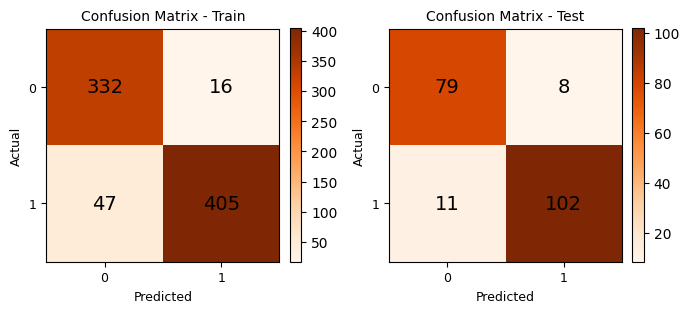

In [ ]:
# -----------------------------
# Confusion Matrices (smaller fig, green cmap, larger cell font)
# -----------------------------
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test  = confusion_matrix(y_test,  y_test_pred)

fig_cm, axes = plt.subplots(1, 2, figsize=(7, 3.2))  # reduced size
for ax, cm, title in zip(
    axes, [cm_train, cm_test], ["Confusion Matrix - Train", "Confusion Matrix - Test"]
):
    im = ax.imshow(cm, cmap="Oranges")  # Oranges colormap
    ax.set_title(title, fontsize=10)
    ax.set_xlabel("Predicted", fontsize=9)
    ax.set_ylabel("Actual", fontsize=9)
    ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
    ax.set_xticklabels(["0", "1"], fontsize=9); ax.set_yticklabels(["0", "1"], fontsize=9)
    # Larger font inside cells
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="black", fontsize=14)
    fig_cm.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

fig_cm.tight_layout()
fig_cm.savefig("cm_train_test.png", dpi=200, bbox_inches="tight")
plt.show()

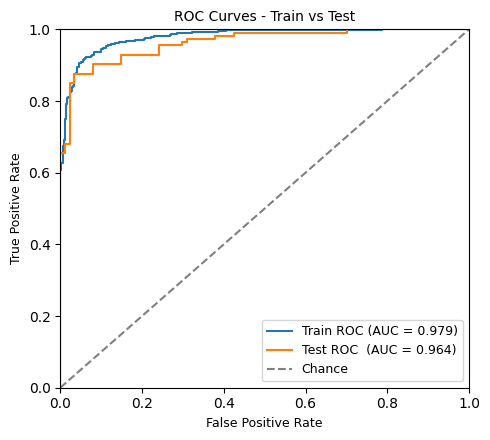

In [ ]:
# -----------------------------
# ROC curves (smaller fig)
# -----------------------------
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
fpr_test,  tpr_test,  _ = roc_curve(y_test,  y_test_prob)
auc_train = auc(fpr_train, tpr_train)
auc_test  = auc(fpr_test,  tpr_test)

fig_roc, ax = plt.subplots(figsize=(5, 4.5))  # reduced size
ax.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {auc_train:.3f})")
ax.plot(fpr_test,  tpr_test,  label=f"Test ROC  (AUC = {auc_test:.3f})")
ax.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Chance")
ax.set_title("ROC Curves - Train vs Test", fontsize=10)
ax.set_xlabel("False Positive Rate", fontsize=9)
ax.set_ylabel("True Positive Rate", fontsize=9)
ax.legend(fontsize=9)
ax.set_xlim(0, 1); ax.set_ylim(0, 1)
fig_roc.tight_layout()
fig_roc.savefig("roc_train_test.png", dpi=200, bbox_inches="tight")
plt.show()

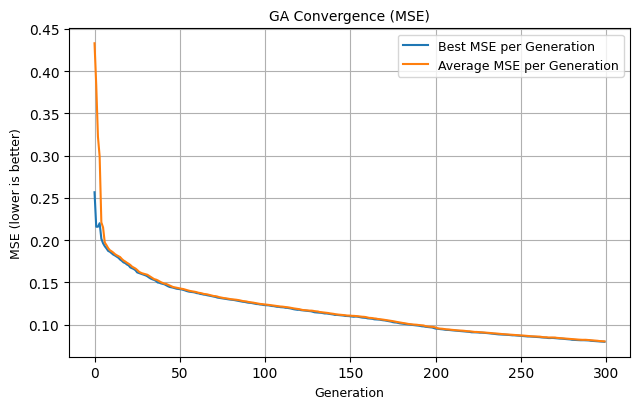


Saved files:
 - cm_train_test.png
 - roc_train_test.png
 - ga_mse_convergence.png
 - classification_metrics.csv


In [ ]:
# -----------------------------
# GA convergence curves as **MSE** (smaller fig)
# -----------------------------
fig_ga, ax = plt.subplots(figsize=(6.5, 4.2))  # reduced size
ax.plot(best_mse_hist, label="Best MSE per Generation")
ax.plot(avg_mse_hist,  label="Average MSE per Generation")
ax.set_title("GA Convergence (MSE)", fontsize=10)
ax.set_xlabel("Generation", fontsize=9)
ax.set_ylabel("MSE (lower is better)", fontsize=9)
ax.legend(fontsize=9)
fig_ga.tight_layout()
fig_ga.savefig("ga_mse_convergence.png", dpi=200, bbox_inches="tight")
plt.grid(True)
plt.show()

# -----------------------------
# Save metrics table
# -----------------------------
metrics_df.to_csv("classification_metrics.csv")
print("\nSaved files:")
print(" - cm_train_test.png")
print(" - roc_train_test.png")
print(" - ga_mse_convergence.png")
print(" - classification_metrics.csv")

In [ ]:
df.describe()

,Age,Sex,Height (in),Weight (lb),BMI>30,Neck>17,Airway MF,MF >2,BAN,AHI,OSA,Age_Group,Height_Group,Weight_Group
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,999.000000,999.000000,999.000000
mean,54.031000,0.592000,67.037000,227.653000,0.689000,0.661000,2.722000,0.582000,1.932000,29.199000,0.565000,2.025025,2.051051,2.007007
std,14.320374,0.491709,4.624339,58.216731,0.463134,0.473607,1.007835,0.493477,1.018043,27.862766,0.496005,0.829307,0.784619,0.818713
min,19.000000,0.000000,15.000000,49.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,44.000000,0.000000,64.000000,186.750000,0.000000,0.000000,2.000000,0.000000,1.000000,7.000000,0.000000,1.000000,1.000000,1.000000
50%,54.000000,1.000000,67.000000,220.000000,1.000000,1.000000,3.000000,1.000000,2.000000,20.000000,1.000000,2.000000,2.000000,2.000000
75%,65.000000,1.000000,70.000000,262.000000,1.000000,1.000000,4.000000,1.000000,3.000000,44.000000,1.000000,3.000000,3.000000,3.000000
max,96.000000,1.000000,79.000000,500.000000,1.000000,1.000000,4.000000,1.000000,3.000000,155.000000,1.000000,3.000000,3.000000,3.000000
